Implement Kendall's shape space and compute the Frechet mean.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [2]:
# Preprocessing: project an object onto the preshape sphere by removing its centroid and scaling it to unit norm

def project_preshape(obj):
    mean_mat = np.tile(obj.mean(0), (len(obj), 1))
    rmv_centroid = np.subtract(obj, mean_mat)
    scaled_obj = rmv_centroid / np.linalg.norm(rmv_centroid)
    return scaled_obj

In [3]:
# Perform Ordinary (a.k.a. Orthogonal) Procrustes Analysis (OPA).
    # Input: target preshape and moving preshape
    # Output: aligned version of the moving preshape

def OPA(target, moving):
    yTx = np.matmul(target.T, moving)
    U, S, VT = np.linalg.svd(yTx)
    #true_S = np.zeros((U.shape[1], VT.shape[0]))
    #true_S[:S.size, :S.size] = np.diag(S)
    Q = np.matmul(U, VT)
    aligned = np.matmul(Q, moving.T).T
    return aligned

In [4]:
# Compute the log map on Kendall shape space
    # given two preshapes, compute the tangent vector at the first preshape that is the initial condition of the geodesic segment between the two

def logMap(ps1, ps2, printAlign=False): #preshape 1, preshape 2
    yTx = np.matmul(ps1.T, ps2)
    U, S, VT = np.linalg.svd(yTx)
    inner_prod = np.sum(np.diag((S)))
    if(inner_prod > 1):
        inner_prod = inner_prod - 0.00001
    opa = OPA(ps1, ps2)
    diff = np.subtract(opa, inner_prod*ps1)
    scale = np.linalg.norm(diff)
    v = (diff / scale) * math.acos(inner_prod)
    return v

In [5]:
#Compute the exponential map on Kendall shape space
    # given a preshape and tangent vector, compute the preshape at the end of the corresponding geodesic

def expMap(ps, v): #preshape and tangent vector
    norm = np.linalg.norm(v)
    if norm == 0: return ps
    endpt = math.cos(norm)*ps + math.sin(norm)*(v/norm)
    return endpt

In [6]:
# Estimate the Frechet mean shape using gradient descent

def frechet_mean(objs):
    proj_objs = []
    for o in objs:
        proj_objs.append(project_preshape(o))
    muk = proj_objs[0]
    log_map = []
    for k in range(0, 500):
        sum_logs = np.zeros((len(muk), len(muk[0])))
        for ps in proj_objs:
            if np.array_equal(muk, ps):
                continue
            log_map = logMap(muk, ps)
            sum_logs = np.add(sum_logs, log_map)
        sum_logs = sum_logs / len(proj_objs)
        muk = expMap(muk, sum_logs)
    return muk

In [7]:
# Compute the approximate principal geodesic analysis-- perform principal component analysis in the tangent space to the Frechet mean.

def PGA(objs):
    mu = frechet_mean(objs)
    S = np.zeros((len(objs[0])*len(objs[0][0]), len(objs[0])*len(objs[0][0])))
    proj_objs = []
    for o in objs:
        ps = project_preshape(o)
        proj_objs.append(ps)
        log_map = logMap(mu, ps)
        log_map_1d = log_map.reshape(len(log_map)*len(log_map[0]),1,order='F').copy()
        S = np.add(S, np.matmul(log_map_1d, log_map_1d.T))
    S = S / (len(objs)-1)
    U, Cov, VT = np.linalg.svd(S)
    eigenvals = np.diag(Cov)
    eigh = np.linalg.eigh(S)
    return {'U': eigh[1], 'eigenvals': eigenvals}

For projecting to the preshape, my implementation essentially just took the mean of the object, subtracted it from each coordinate, and then normalized the resulting matrix using Frobenius norm. For OPA, I used the solution to the Procrustes problem to set up my matrices, making use of the numpys svd function, and returning the aligned matrix. This section was a little confusing at first with getting the moving and target order correct. My log map involved finding the trace of the svd of the product of the two preshapes and also calling the OPA function to use these two values in the log map formula to get the tangent vector. My exponential map normalized the tangent vector and then returned the endpoint based on the formula for the exponential map. My frechet mean essentially found the log map from the mean to every other input, then updated the mean using the exponential map, and continued doing this for 500 iterations. For PGA, I essentially kept updating the S matrix by taking the log map of the mean to each input point, and at the end of it, I returned the svd/eigenanalysis of the S matrix. I had some trouble with the eigenvectors when using svd, so instead of svd for the eigenvectors I used the eigenanalysis method provided by numpy.linalg. 

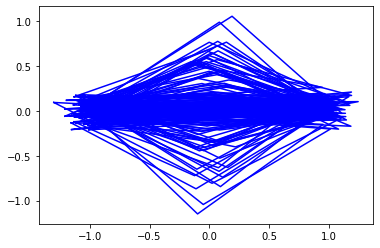

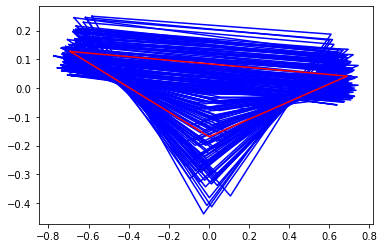

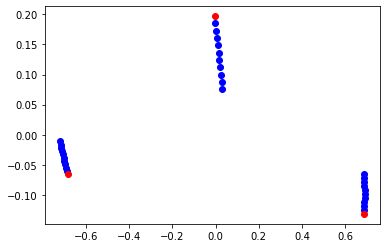

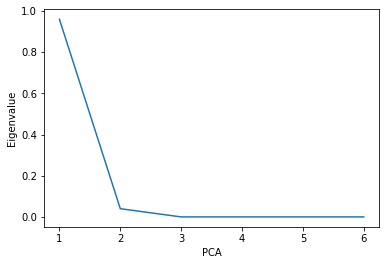

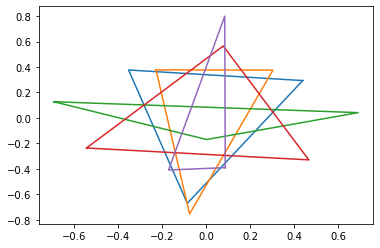

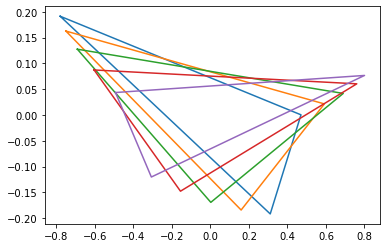

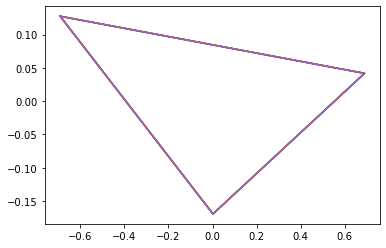

In [10]:
#Triangle Experiment
s_array = np.random.normal(0, 0.5, 100)
triangles = []
triangles_ps = [] #triangle preshapes
for s in s_array:
    points = np.array([np.array([-1, 0]), np.array([1, 0]), np.array([0, s])])
    triangles.append(points)
for i in range(0, len(triangles)):
    for j in range(0, len(triangles[0])):
        for k in range(0, len(triangles[0][0])):
            triangles[i][j][k] += np.random.normal(0, 0.1, 1)[0]
triangles = np.array(triangles)
#print(triangles)
for t in triangles:
    toPlot = np.vstack([t, t[0]]) #Need to add first point again to print
    plt.plot(toPlot[:, 0], toPlot[:, 1], 'b')
    ps = project_preshape(t)
    triangles_ps.append(ps)
plt.show()
triangles_ps = np.array(triangles_ps)
mean = frechet_mean(triangles)
for ps in triangles_ps:
    aligned = OPA(mean, ps)
    toPlot = np.vstack([aligned, aligned[0]]) #Need to add first point again to print
    plt.plot(toPlot[:, 0], toPlot[:, 1], 'b')
mean_plot = np.vstack([mean, mean[0]]) #Need to add first point again to print
plt.plot(mean_plot[:, 0], mean_plot[:, 1], 'r')
plt.show()
log_map = logMap(triangles_ps[22], triangles_ps[45])
for i in range(0, 11):
    exp_map = expMap(triangles_ps[22], log_map*(i/10))
    if i < 10:
        plt.plot(exp_map[:, 0], exp_map[:, 1], 'bo')
    else:
        plt.plot(exp_map[:, 0], exp_map[:, 1], 'ro')
plt.show()
pga = PGA(triangles)
U = pga['U']
eigs = pga['eigenvals']
eigenvalues = []
for i in range(0, len(eigs)):
    eigenvalues.append(eigs[i][i])
eigenvalues = np.array(eigenvalues)
eigenvalues = eigenvalues**2/np.sum(eigenvalues**2)
sing_vals=np.arange(len(eigenvalues)) + 1
plt.plot(sing_vals, eigenvalues)
plt.xlabel("PCA")
plt.ylabel("Eigenvalue")
plt.show()
shapes = []
for col in U.T:
    shapes.append(np.reshape(col, (-1, 2), order='F'))
#First Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[0]**(1/2))*shapes[-1])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()
#Second Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[1]**(1/2))*shapes[-2])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()
#Third Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[2]**(1/2))*shapes[-3])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()


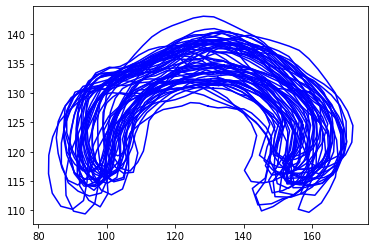

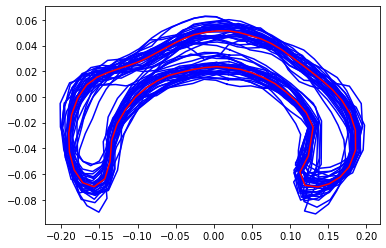

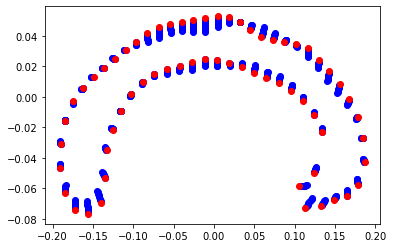

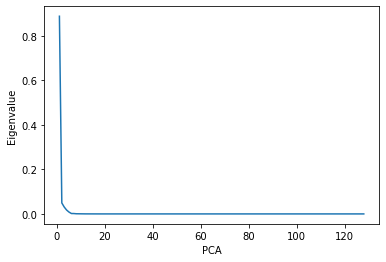

[8.88404752e-01 4.93414840e-02 3.10030101e-02 1.73955266e-02
 8.27945675e-03 1.78797736e-03 1.68079216e-03 7.19899362e-04
 4.69757124e-04 3.05176878e-04 2.77632742e-04 1.66358341e-04
 5.97944982e-05 4.22016460e-05 1.57055337e-05 1.49023299e-05
 1.03121037e-05 8.92819666e-06 6.79384602e-06 3.18918763e-06
 2.01180272e-06 1.32041709e-06 7.97456205e-07 6.59910174e-07
 5.27088461e-07 2.98637129e-07 2.59321885e-07 1.97314367e-07
 1.48901201e-07 7.63512690e-08 5.20515255e-08 8.96585842e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.74086641e-33 8.74086641e-33 8.74086641e-33
 8.74086641e-33 8.740866

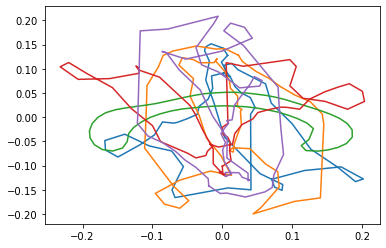

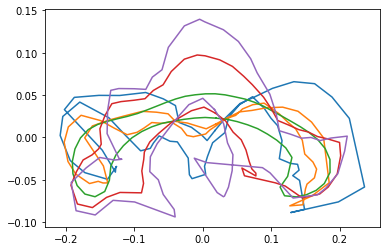

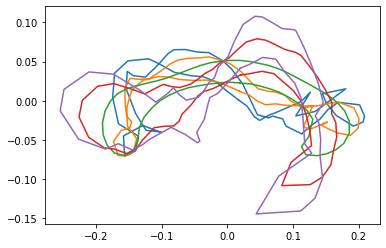

In [11]:
objects = []
objects_ps = []
for filename in os.listdir("cc-shapes"):
    f = os.path.join("cc-shapes", filename)
    with open(f) as file:
        obj = []
        for line in file:
            point_str = np.array(line.rstrip().split(" "))
            point = point_str.astype(float)
            obj.append(point)
        objects.append(np.array(obj))
objects = np.array(objects)
for o in objects:
    toPlot = np.vstack([o, o[0]]) #Need to add first point again to print
    plt.plot(toPlot[:, 0], toPlot[:, 1], 'b')
    ps = project_preshape(o)
    objects_ps.append(ps)
plt.show()
objects_ps = np.array(objects_ps)
mean = frechet_mean(objects)
for ps in objects_ps:
    aligned = OPA(mean, ps)
    toPlot = np.vstack([aligned, aligned[0]]) #Need to add first point again to print
    plt.plot(toPlot[:, 0], toPlot[:, 1], 'b')
mean_plot = np.vstack([mean, mean[0]]) #Need to add first point again to print
plt.plot(mean_plot[:, 0], mean_plot[:, 1], 'r')
plt.show()
log_map = logMap(objects_ps[12], objects_ps[22])
for i in range(1, 11):
    exp_map = expMap(objects_ps[12], log_map*(i/10))
    if i < 10:
        plt.plot(exp_map[:, 0], exp_map[:, 1], 'bo')
    else:
        plt.plot(exp_map[:, 0], exp_map[:, 1], 'ro')
plt.show()
pga = PGA(objects)
U = pga['U']
eigs = pga['eigenvals']
eigenvalues = []
for i in range(0, len(eigs)):
    eigenvalues.append(eigs[i][i])
eigenvalues = np.array(eigenvalues)
eigenvalues = eigenvalues**2/np.sum(eigenvalues**2)
sing_vals=np.arange(len(eigenvalues)) + 1
plt.plot(sing_vals, eigenvalues)
plt.xlabel("PCA")
plt.ylabel("Eigenvalue")
plt.show()
print(eigenvalues)
shapes = []
for col in U.T:
    shapes.append(np.reshape(col, (-1, 2), order='F'))
#First Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[0]**(1/2))*shapes[-1])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()
#Second Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[1]**(1/2))*shapes[-2])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()
#Third Eigenvalue/Mode
for i in range(-2, 3):
    mode = expMap(mean, i*(eigenvalues[2]**(1/2))*shapes[-3])
    toPlot = np.vstack([mode, mode[0]]) #Need to add first point again to print
    plt.plot(toPlot[:,0], toPlot[:,1])
plt.show()


For both experiments, I first plot the raw objects. Then, I, project the objects to the preshape and align them to the mean. For both experiments, there is an obvious difference in the aligned shapes. In red is the mean shape. Then, I plot a geodesic between two objects from the data set. The red is the second point and the blue is the first. There are a total of ten points from a blue to red point to visualize the deformation into the other. 

Looking at the scree plot for the triangle experiment, I would use 2 modes to describe that data. For the other shape experiment, the scree plot isnt obvious, but after printing out the eigenvalues for that plot, I determine that we would use 31 modes to describe that data.

Next, for both experiments, I have plotted the modes of variation for three modes. For the triangles, for the first mode I observe that the triangles get thinner and taller which is what I expect. And for the second mode, I see that the center of the triangle is shifting horizontally which is also expected because that is essentially the other degree of freedom. Finally, the third mode has essentially one shape which is to be expected since we dont expect variation with the third mode.

The maximum number of modes for triangle is 2 because only the third point has variation, and can move left/right or up/down for two modes. In general, the maximum number of nodes would be 2(n-2) because after the second point, all points add an additional 2 degrees of freedom.